In [1]:
import scanpy as sc
import pandas as pd
import xarray as xr
from numpy import ones
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import time
from limix.qc import quantile_gaussianize

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-oq10ye0b because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
import cellregmap
cellregmap 

<module 'cellregmap' from '/share/ScratchGeneral/anncuo/github_repos/CellRegMap/cellregmap/__init__.py'>

In [3]:
from cellregmap import run_interaction

In [4]:
chrom = 1

In [5]:
mydir = "/share/ScratchGeneral/anncuo/OneK1K/"
input_files_dir = "/share/ScratchGeneral/anncuo/OneK1K/input_files_CellRegMap/"

In [6]:
## sample mapping file
## this file will map cells to donors 
## here, B cells only
sample_mapping_file = input_files_dir+"smf_Bcells.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"individual_long": str, "genotype_individual_id": str, "phenotype_sample_id": str}, index_col=0)

In [7]:
sample_mapping.head()

,phenotype_sample_id,genotype_individual_id,individual_long
1,AAACCTGCAACGATCT-1,687,686_687
2,AAACCTGGTCAGAATA-1,693,692_693
3,AAACGGGAGCGTCAAG-1,693,692_693
4,AAACGGGAGGGAACGG-1,691,690_691
5,AAACGGGCAGTTCATG-1,683,682_683


In [8]:
## extract unique individuals
donors0 = sample_mapping["genotype_individual_id"].unique()
donors0.sort()
print("Number of unique donors: {}".format(len(donors0)))

Number of unique donors: 981


In [9]:
#### kinship file

In [10]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_file="/share/ScratchGeneral/anncuo/OneK1K/input_files_CellRegMap/grm_wide.csv"
K = pd.read_csv(kinship_file, index_col=0)
K.index = K.index.astype('str')
assert all(K.columns == K.index) #symmetric matrix, donors x donors

/share/ScratchGeneral/anncuo/jupyter/conda_notebooks/envs/cellregmap_notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors0))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 981


In [12]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

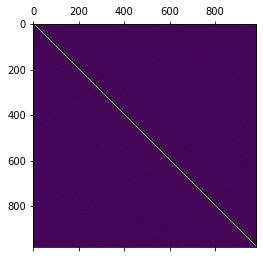

In [13]:
plt.matshow(K)

In [14]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [15]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 133716
Sample mapping number of rows AFTER intersection: 133716


In [16]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [17]:
hK_expanded.shape

(133716, 981)

In [18]:
#### phenotype file

In [19]:
# open anndata 
my_file = "/share/ScratchGeneral/anncuo/OneK1K/expression_objects/sce"+str(chrom)+".h5ad"
adata = sc.read(my_file)
# sparse to dense
mat = adata.raw.X.todense()
# make pandas dataframe
mat_df = pd.DataFrame(data=mat.T, index=adata.raw.var.index, columns=adata.obs.index)
# turn into xr array
phenotype = xr.DataArray(mat_df.values, dims=["trait", "cell"], coords={"trait": mat_df.index.values, "cell": mat_df.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)

In [20]:
del mat
del mat_df

In [21]:
phenotype.shape

(2510, 133716)

In [22]:
phenotype.head()

<xarray.DataArray (trait: 5, cell: 5)>
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
Coordinates:
  * trait    (trait) object 'AL627309.1' 'AL645728.1' ... 'C1orf134'
  * cell     (cell) object 'AAACCTGCAACGATCT-1' ... 'AAACGGGCAGTTCATG-1'

In [23]:
#### genotype file

In [24]:
## read in genotype file (plink format)
plink_folder = "/share/ScratchGeneral/anncuo/OneK1K/plink_files/"
plink_file = plink_folder+"plink_chr"+str(chrom)+".bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


In [25]:
G

<xarray.DataArray 'genotype' (sample: 1034, variant: 406731)>
dask.array<transpose, shape=(1034, 406731), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
  * variant  (variant) <U13 'variant0' 'variant1' ... 'variant406730'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '1' '1' '1' '1' '1' '1' ... '1' '1' '1' '1' '1'
    snp      (variant) object '1:729679' '1:731718' ... '1:249209648'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 729679 731718 734349 ... 249174682 249209648
    a0       (variant) object 'G' 'C' 'C' 'A' 'A' 'G' ... 'C' 'T' 'C' 'A' 'A'
    a1       (variant) object 'C' 'T' 'T' 'T' 'G' 'A' ... 'T' 'G' 'A' 'G' 'G'

In [26]:
G.shape

(1034, 406731)

In [27]:
# change this to select known eQTLs instead

In [28]:
# Filter on specific gene-SNP pairs
# eQTL from B cells (B IN + B Mem)
Bcell_eqtl_file = input_files_dir+"fvf_Bcell_eqtls.csv"
Bcell_eqtl = pd.read_csv(Bcell_eqtl_file, index_col = 0)
Bcell_eqtl.head()

,feature,snp_id,chrom
1,RP11-298J20.3,10:126644482,10
2,PPA1,10:71963608,10
3,GDI2,10:5855403,10
4,OPTN,10:13160035,10
5,MGMT,10:131279791,10


In [29]:
genes = Bcell_eqtl[Bcell_eqtl['chrom']==int(chrom)]['feature'].unique()
genes

array(['FCRL5', 'RPS8', 'CHI3L2', 'TSTD1', 'MGST3', 'KIAA0040', 'RPL11',
       'FAM177B', 'MDM4', 'FCRL3', 'SH3BGRL3', 'DRAM2', 'PNRC2', 'CD52',
       'RCSD1', 'CCDC163P', 'GALNT2', 'CDC42', 'SLC2A1-AS1', 'ITGB3BP',
       'FLVCR1-AS1', 'GSTM4', 'ECHDC2', 'FCRLA', 'VAV3-AS1', 'C1orf86',
       'SRSF10', 'RGS1', 'FCRL2', 'RP11-386I14.4', 'SELL', 'CCT3',
       'MARC2', 'UQCRH', 'SLC16A4', 'VAV3', 'GBP7', 'LINC00339', 'PARK7',
       'ENO1', 'NSUN4', 'DIEXF', 'NTPCR', 'USF1', 'RP5-827C21.4', 'LY9',
       'RP11-108M9.4', 'RP11-69E11.4', 'DEGS1', 'CTSS', 'PHACTR4',
       'C1orf115', 'VAMP4', 'LYST', 'C1orf220', 'H6PD', 'ALDH9A1',
       'RAP1A', 'ARV1', 'NBPF1', 'TCEB3', 'ANGEL2', 'MACF1',
       'RP4-594I10.3', 'LEPROT', 'DNAJC16', 'C1orf63', 'RGS16', 'LRRIQ3',
       'TEX35', 'FCRL1', 'RP5-1098D14.1', 'LAX1', 'THEMIS2', 'LRIF1',
       'MIR181A1HG', 'CD53', 'SYNC', 'AL592284.1', 'MSTO1', 'FCGR2B',
       'PTPN22', 'MTHFR', 'SCCPDH', 'NME7', 'VPS72', 'KLHL21', 'ARID1A',
       'PADI4'

In [30]:
# (1) gene name (feature_id)
# gene_name = genes[128]
# gene_name

In [31]:
# hard-code missing genes
# chromosome 1: 'CTH''GSTM3''CITED4'
# chromosome 5: 'SNX24''MGAT4B'

In [32]:
gene_name = 'CTH'

In [33]:
# select SNPs for a given gene
leads = Bcell_eqtl[Bcell_eqtl['feature']==gene_name]['snp_id'].unique()
leads

array(['1:71220239', '1:71222145', '1:71225448'], dtype=object)

In [34]:
#breakpoint()
G_sel = G[:,G['snp'].isin(leads)]

In [35]:
G_sel

<xarray.DataArray 'genotype' (sample: 1034, variant: 3)>
dask.array<getitem, shape=(1034, 3), dtype=float32, chunksize=(1024, 3), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
  * variant  (variant) <U13 'variant122732' 'variant122737' 'variant122741'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object '1_1' '2_2' '3_3' ... '1103_926_2' '1104_920_2'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '1' '1' '1'
    snp      (variant) object '1:71220239' '1:71222145' '1:71225448'
    cm       (variant) float64 0.0 0.0 0.0
    pos      (variant) int32 71220239 71222145 71225448
    a0       (variant) object 'C' 'A' 'T'
    a1       (variant) object 'G' 'G' 'C'

In [36]:
# expand out genotypes from cells to donors (and select relevant donors in the same step)
G_expanded = G_sel.sel(sample=sample_mapping["individual_long"].values)
# assert all(hK_expanded.sample.values == G_expanded.sample.values)

/share/ScratchGeneral/anncuo/jupyter/conda_notebooks/envs/cellregmap_notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 291 times more chunks
  return self.array[key]


In [37]:
G_expanded.shape

(133716, 3)

In [38]:
del G

In [39]:
#### context file

In [40]:
# cells (B cells only) by PCs
# C_file = input_files_dir+"PCs_Bcells.csv"
# C = pd.read_csv(C_file, index_col = 0)
C_file = input_files_dir+"PCs_Bcells.csv.pkl"
C = pd.read_pickle(C_file)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [41]:
C.shape

(133716, 50)

In [42]:
C_gauss = quantile_gaussianize(C)

In [43]:
# select gene
y = phenotype.sel(trait=gene_name)

In [44]:
[(y == 0).astype(int).sum()/len(y)]

[<xarray.DataArray ()>
 array(0.99816776)
 Coordinates:
     trait    <U3 'CTH']

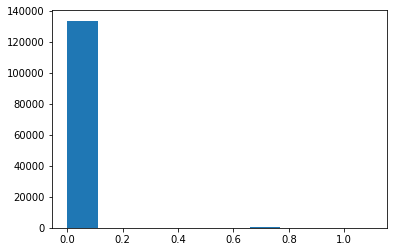

In [45]:
plt.hist(y)
plt.show()

In [46]:
y = quantile_gaussianize(y)

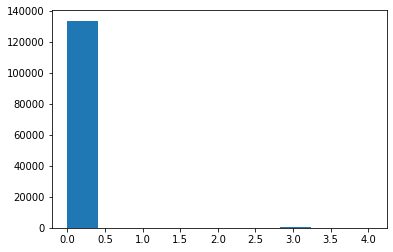

In [47]:
plt.hist(y)
plt.show()

In [48]:
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))

In [49]:
del phenotype

In [50]:
start_time = time.time()
GG = G_expanded.values
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.23962640762329102 seconds ---


In [51]:
# del G_expanded
del G_sel

In [52]:
# myfolder = mydir+"CellRegMap_example_files/"
# import numpy as np
# np.save(myfolder+"pheno.npy",y)
# np.save(myfolder+"covs.npy",W)
# np.save(myfolder+"context.npy",C.values[:,0:10])
# np.save(myfolder+"geno.npy",GG[:,0:10])
# np.save(myfolder+"hK",hK_expanded)

In [53]:
start_time = time.time()
pvals = run_interaction(y=y, W=W, E=C.values[:,0:10], G=GG, hK=hK_expanded)[0]
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
pv = pd.DataFrame({"chrom":G_expanded.chrom.values,
               "pv":pvals,
               "variant":G_expanded.snp.values})
pv.head()

In [ ]:
## took over an hour to run for one SNP!

In [ ]:
gene_name

In [ ]:
folder = mydir + "CRM_interaction/Bcells_Bcell_eQTLs/"
outfilename = f"{folder}{gene_name}.tsv"
print(outfilename)

In [ ]:
import os
if os.path.exists(outfilename):
    print("File already exists, exiting")

In [ ]:
pv.to_csv(outfilename)